* find k companies' adj close price history, compute daily return  
* daily return = (today's price - yesterday's price)/yesterday's price  
* final df: date, ticker, return;  

find the pair wise correlation of the k companies; (average correlation)  

In [2]:
import pandas as pd
import numpy as np
import os
import dill
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from functools import reduce

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.mode.chained_assignment = None 

In [3]:
code_dir = os.getcwd()
data_dir = code_dir.replace('code', 'data')
historical_price = pd.read_csv(data_dir+'/Historical_Prices_all.csv', index_col=0)

/Users/annzhong/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
cluster_kmeans=dill.load(open(data_dir+'/classification/clusters_kmeans_tokened.pkd', 'rb'))

In [5]:
# len(cluster_kmeans) = 4
historical_price.columns = ['sec_id','date','open','close','volume','adj.close','ticker']
data = historical_price[['date','adj.close','ticker']]

In [61]:
cluster0 = data[data['ticker'].isin(cluster_kmeans[0])]
cluster1 = data[data['ticker'].isin(cluster_kmeans[1])]
cluster2 = data[data['ticker'].isin(cluster_kmeans[2])]
cluster3 = data[data['ticker'].isin(cluster_kmeans[3])]

In [187]:
countlist = cluster3.groupby('ticker').size().tolist()
c = Counter(countlist)
c.most_common(2)

[(4495, 5), (4491, 4)]

In [107]:
def get_return(df, ticker):
    df['yesterday']=df['adj.close'].shift(1)
    df[ticker] = ((df['adj.close'].astype(float)-
                   df['yesterday'].astype(float))/df['yesterday'].astype(float))
    return df[['date', ticker]]


In [223]:
def get_return_df(ticker_list, cluster_df):
    return_dfs = []
    for ticker in ticker_list:
        df = cluster_df[cluster_df['ticker'] == ticker]
        returns = get_return(df, ticker)
        if len(returns) > 2:
            return_dfs.append(returns)
    return return_dfs

In [224]:
# find returns for cluster1
return_df0 = get_return_df(ticker_list = cluster_kmeans[0], cluster_df = cluster0)
return_df1 = get_return_df(ticker_list = cluster_kmeans[1], cluster_df = cluster1)
return_df2 = get_return_df(ticker_list = cluster_kmeans[2], cluster_df = cluster2)
return_df3 = get_return_df(ticker_list = cluster_kmeans[3], cluster_df = cluster3)

In [231]:
def merge_dfs(return_dfs):
    merge_dfs = reduce(lambda x, y: pd.merge(x, y, on='date', how='outer'), return_dfs)
    merge_dfs = merge_dfs.drop(0, axis=0)
    merge_dfs = merge_dfs.drop('date', axis=1)
    
    return merge_dfs

In [232]:
merge_df0 = merge_dfs(return_df0)
merge_df1 = merge_dfs(return_df1)
merge_df2 = merge_dfs(return_df2)
merge_df3 = merge_dfs(return_df3)

In [241]:
merge_dfs = [merge_df0, merge_df1, merge_df2, merge_df3]

In [235]:
# replace any nan in column with its average value
for df in merge_dfs:
    col_mean = df.mean(axis=0)
    for name in df.columns:
        df[[name]] = df[[name]].fillna(col_mean[name])


In [242]:
## save all results
# i = 0
# for df in merge_dfs:
#     df.to_pickle('cluster_return'+str(i))
#     i+=1

# calculate correlations

In [243]:
# method : {'pearson', 'kendall', 'spearman'}
def calc_correlation(df, method):
    corr = df.corr(method = method)
    avg_corr = (np.nansum(corr)-len(corr))/2/(len(corr)*(len(corr)-1)/2)
    
    return(corr, avg_corr)

In [244]:
corr_dfs = []
avg_corrs = []
for df in merge_dfs:
    (corr, avg_corr) = calc_correlation(df, 'pearson')
    corr_dfs.append(corr)
    avg_corrs.append(avg_corr)

In [245]:
avg_corrs

[0.10358789186347168,
 0.14755180094896553,
 0.074163612257497305,
 0.1430173304425304]

In [247]:
corr_dfs[0]

,XXIA,HES,XONE,WATT,EBAY,DAIO,BSFT,VOXX
XXIA,1.000000,0.210661,0.061504,0.023172,0.247357,0.105654,0.106919,0.271317
HES,0.210661,1.000000,0.113626,0.061316,0.186349,0.083865,0.118862,0.242839
XONE,0.061504,0.113626,1.000000,0.169948,0.042629,0.028578,0.067712,0.082056
WATT,0.023172,0.061316,0.169948,1.000000,0.020272,0.010754,0.074662,0.013707
EBAY,0.247357,0.186349,0.042629,0.020272,1.000000,0.057025,0.085973,0.227250
DAIO,0.105654,0.083865,0.028578,0.010754,0.057025,1.000000,0.026597,0.068923
BSFT,0.106919,0.118862,0.067712,0.074662,0.085973,0.026597,1.000000,0.090935
VOXX,0.271317,0.242839,0.082056,0.013707,0.227250,0.068923,0.090935,1.000000


In [254]:
import seaborn as sns; sns.set()

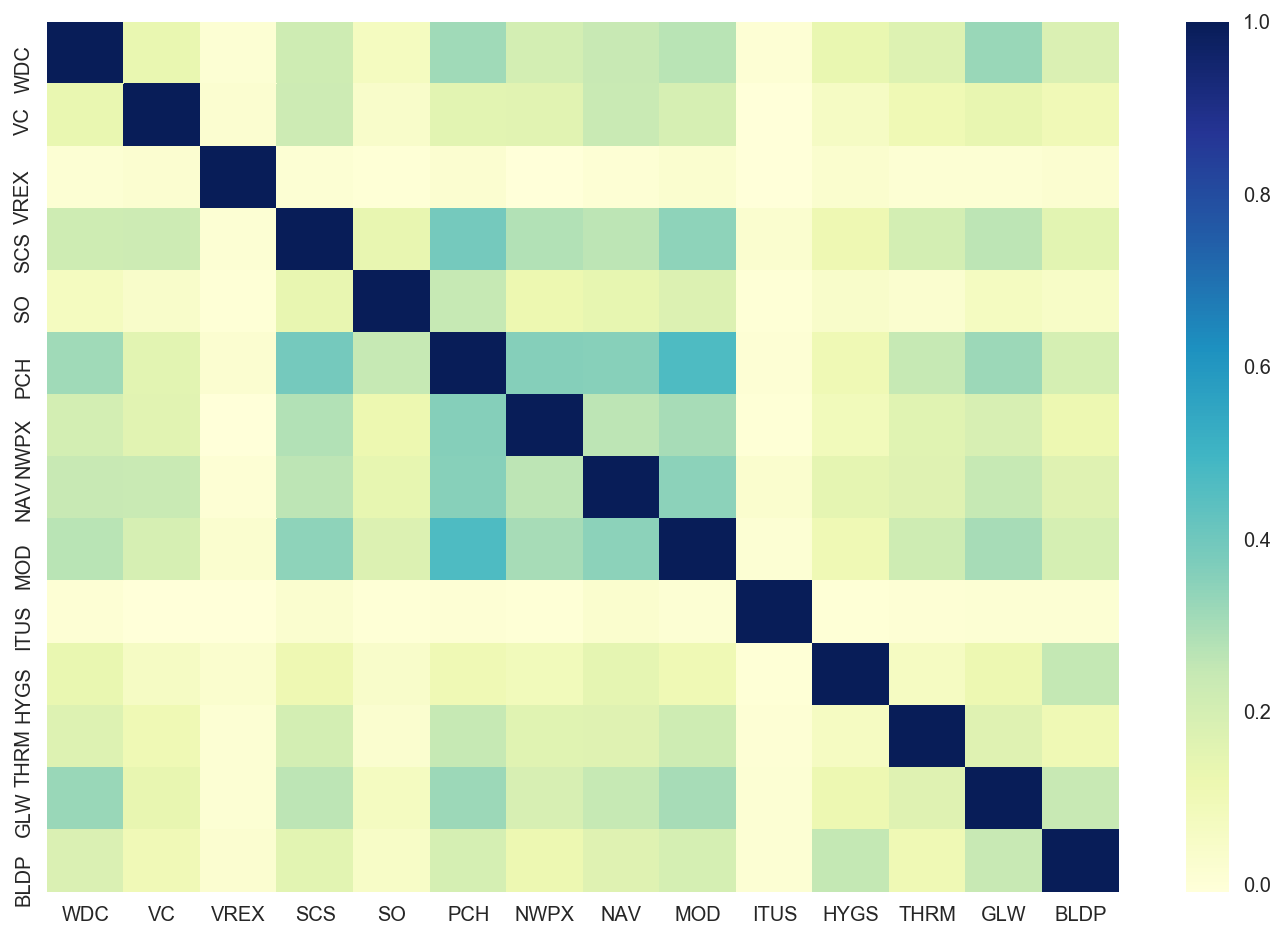

In [261]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_dfs[3], cmap="YlGnBu")
plt.savefig('cluster4_correlation')

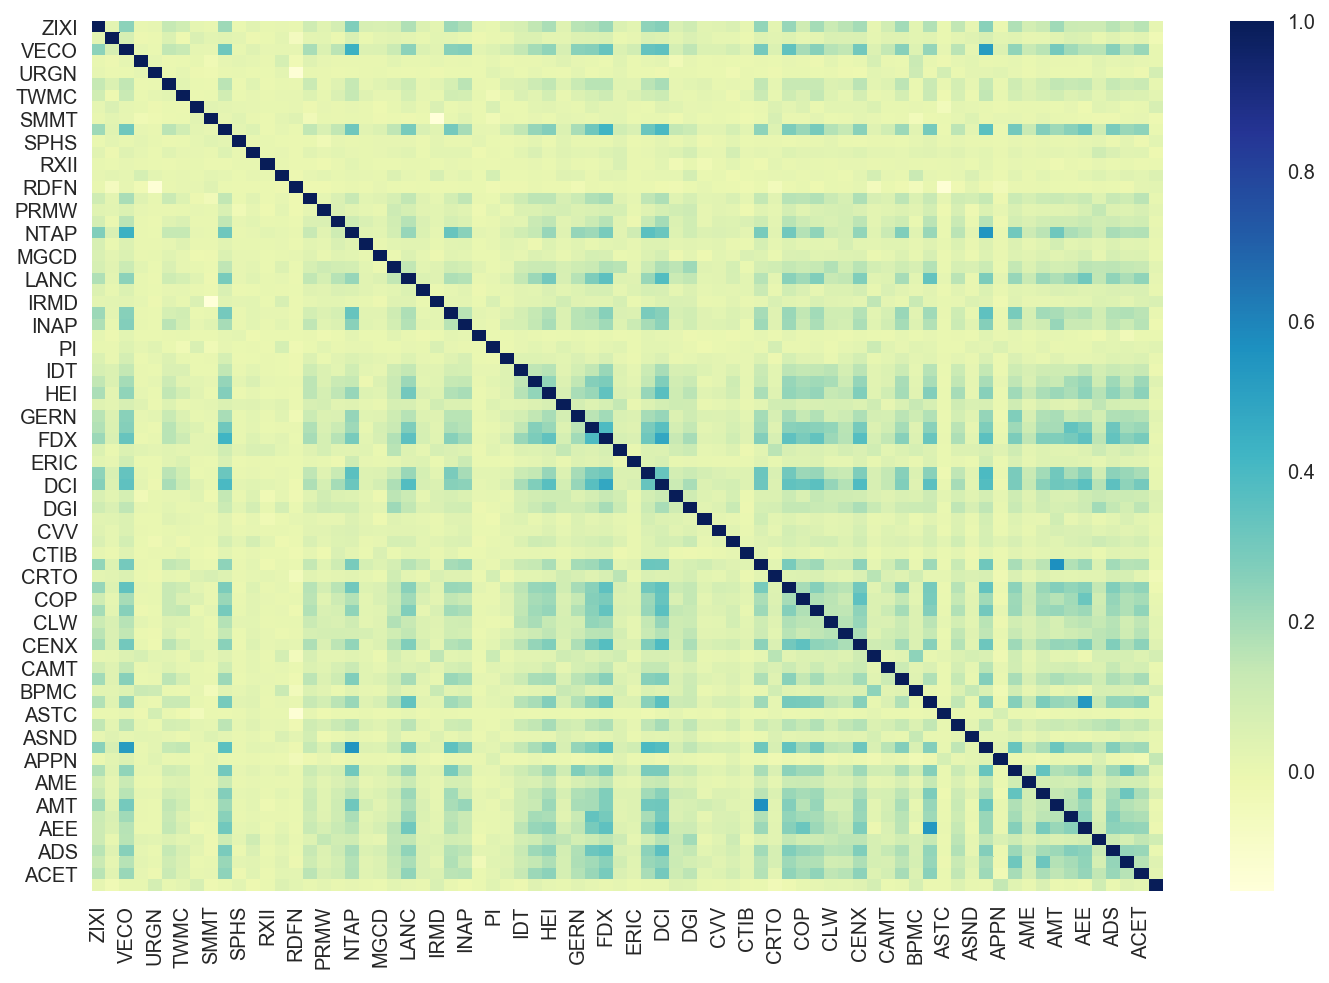

In [262]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_dfs[2], cmap="YlGnBu");
plt.savefig('cluster3_correlation')

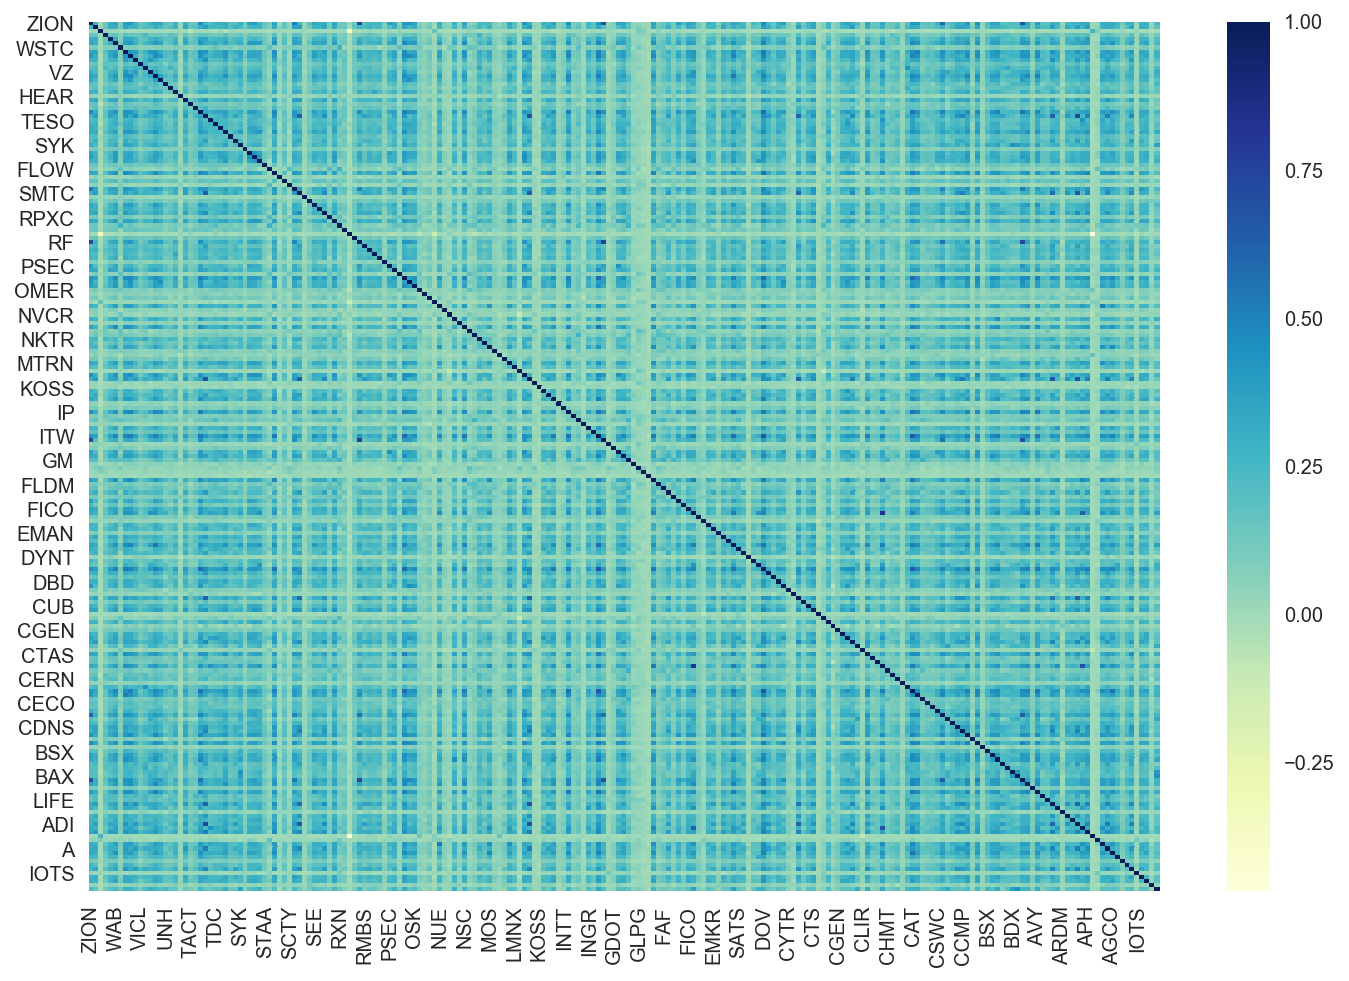

In [263]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_dfs[1], cmap="YlGnBu")
plt.savefig('cluster2_correlation')

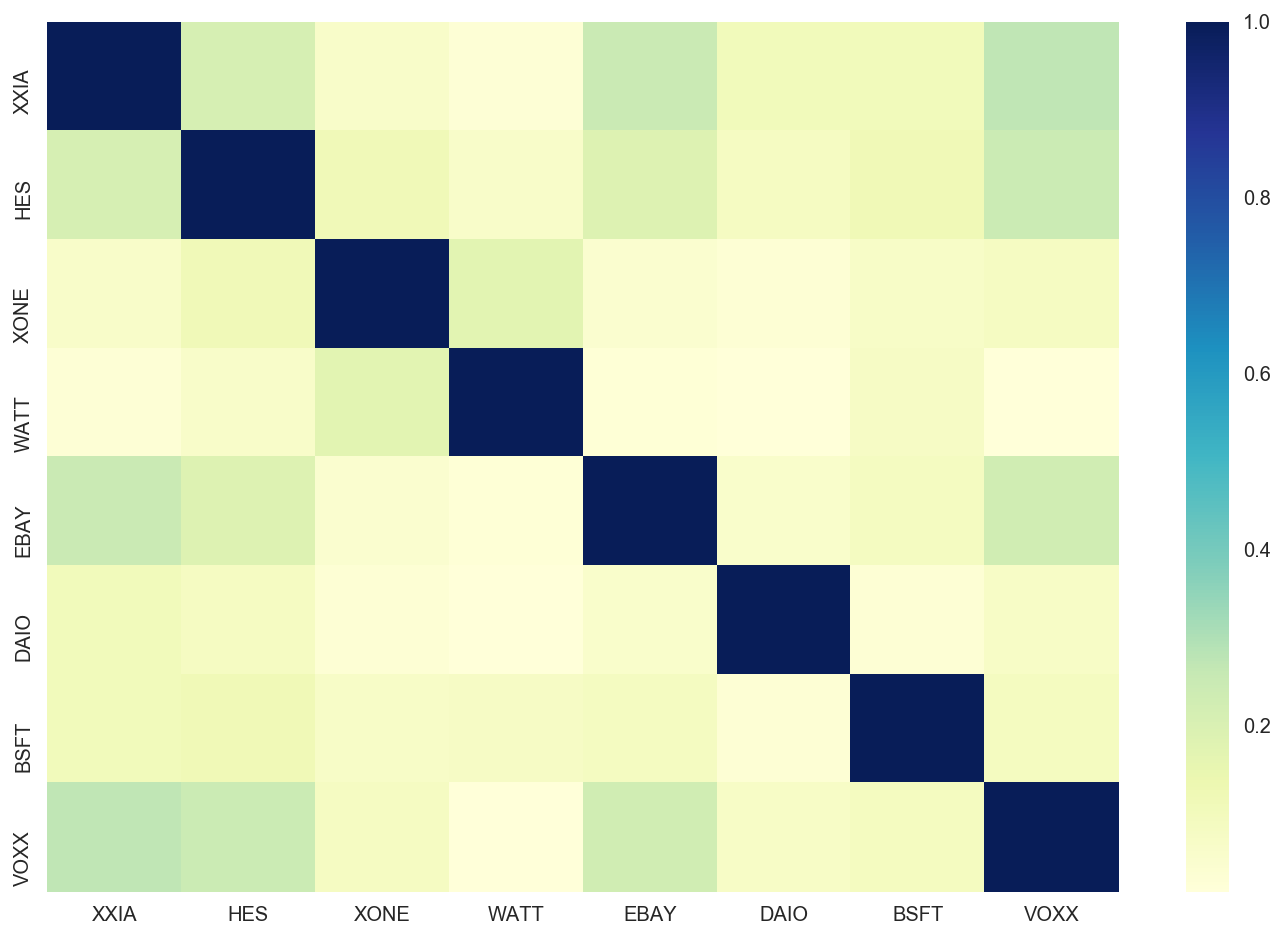

In [264]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_dfs[0], cmap="YlGnBu")
plt.savefig('cluster1_correlation')